In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import sklearn
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
%%time
path = "../input/parse-json-v2-without-hits-column/"
train_df = pd.read_pickle(path + 'train_v2_clean.pkl')
test_df = pd.read_pickle(path + 'test_v2_clean.pkl')

CPU times: user 5.17 s, sys: 11 s, total: 16.1 s
Wall time: 16.3 s


In [3]:
train_df.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,customDimensions_value
0,Organic Search,20171016,3162355547410993243,1508198450,1,1508198450,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Germany,not available in demo dataset,(not set),not available in demo dataset,Western Europe,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,water bottle,organic,NaN,google,EMEA
1,Referral,20171016,8934116514970143966,1508176307,6,1508176307,Chrome,desktop,False,Chrome OS,Cupertino,Americas,United States,San Francisco-Oakland-San Jose CA,(not set),California,Northern America,NaN,2,NaN,2,2,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,NaN,referral,/a/google.com/transportation/mtv-services/bike...,sites.google.com,North America
2,Direct,20171016,7992466427990357681,1508201613,1,1508201613,Chrome,mobile,True,Android,not available in demo dataset,Americas,United States,not available in demo dataset,windjammercable.net,not available in demo dataset,Northern America,NaN,2,1,2,1,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),True,NaN,(none),NaN,(direct),North America
3,Organic Search,20171016,9075655783635761930,1508169851,1,1508169851,Chrome,desktop,False,Windows,not available in demo dataset,Asia,Turkey,not available in demo dataset,unknown.unknown,not available in demo dataset,Western Asia,NaN,2,1,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,EMEA
4,Organic Search,20171016,6960673291025684308,1508190552,1,1508190552,Chrome,desktop,False,Windows,not available in demo dataset,Americas,Mexico,not available in demo dataset,prod-infinitum.com.mx,not available in demo dataset,Central America,NaN,2,1,2,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,Central America


In [4]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'visitId', 'visitNumber',
       'visitStartTime', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'geoNetwork_city',
       'geoNetwork_continent', 'geoNetwork_country', 'geoNetwork_metro',
       'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'totals_bounces', 'totals_hits',
       'totals_newVisits', 'totals_pageviews', 'totals_sessionQualityDim',
       'totals_timeOnSite', 'totals_totalTransactionRevenue',
       'totals_transactionRevenue', 'totals_transactions',
       'trafficSource_adContent',
       'trafficSource_adwordsClickInfo.adNetworkType',
       'trafficSource_adwordsClickInfo.gclId',
       'trafficSource_adwordsClickInfo.isVideoAd',
       'trafficSource_adwordsClickInfo.page',
       'trafficSource_adwordsClickInfo.slot', 'trafficSource_campaign',
       'trafficSource_isTrueDirect', 'trafficSource_keyword',
       'trafficSource_med

# Split data by date.

In [5]:
train_df["date"] = pd.to_datetime(train_df["date"], format="%Y%m%d")
test_df["date"] = pd.to_datetime(test_df["date"], format="%Y%m%d")

In [6]:
train_df['date'].max(),train_df['date'].min()

(Timestamp('2018-04-30 00:00:00'), Timestamp('2016-08-01 00:00:00'))

In [7]:
test_df['date'].max(),test_df['date'].min()

(Timestamp('2018-10-15 00:00:00'), Timestamp('2018-05-01 00:00:00'))

## The Training data is from 2016-08-01 to 2018-04-30, while the Testing data is from 2018-05-01 to 2018-10-15.

## Spliting Training Data Into Preprocessing, Training, Validation.

## Training Set
* Preprocessing  Set ==> 2016/08/01 ~ 2016/09/30 (2 month)
* Training Set  ==> 2016/10/01 ~ 2017/12/31 (13 month)
* Validation Set ==> 2018/01/01 ~ 2018/04/30 (4 month)

In [8]:
pre_set = train_df[(train_df['date']<=pd.datetime(2016,9,30)) & (train_df['date']>=pd.datetime(2016,8,1))]
train_set= train_df[(train_df['date']<=pd.datetime(2017,12,31)) & (train_df['date']>=pd.datetime(2016,10,1))]
val_set = train_df[(train_df['date']<=pd.datetime(2018,4,30)) & (train_df['date']>=pd.datetime(2018,1,1))]
test_set = test_df.copy()

In [9]:
pre_set.shape, train_set.shape, val_set.shape

((145791, 39), (1219462, 39), (343084, 39))

In [10]:
test_set.shape

(401589, 39)

# Preprocess

In [11]:
pre_set.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,customDimensions_value
2989,Organic Search,2016-09-02,9499785259412240342,1472812272,1,1472812272,Firefox,desktop,False,Windows,not available in demo dataset,Europe,Netherlands,not available in demo dataset,chello.nl,not available in demo dataset,Western Europe,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,EMEA
2990,Organic Search,2016-09-02,3696906537737368442,1472856874,1,1472856874,Chrome,desktop,False,Windows,Buenos Aires,Americas,Argentina,(not set),phonevision.com.ar,Buenos Aires,South America,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,South America
2991,Organic Search,2016-09-02,5688512451361930466,1472811524,1,1472811524,Chrome,desktop,False,Linux,Bengaluru,Asia,India,(not set),acttv.in,Karnataka,Southern Asia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,APAC
2992,Organic Search,2016-09-02,9716453263501147451,1472823508,1,1472823508,Safari,mobile,True,iOS,New Delhi,Asia,India,(not set),unknown.unknown,Delhi,Southern Asia,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,APAC
2993,Organic Search,2016-09-02,5330453591145100432,1472839619,1,1472839619,Chrome,desktop,False,Windows,Sao Paulo,Americas,Brazil,(not set),teleperformance.com.br,State of Sao Paulo,South America,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,South America


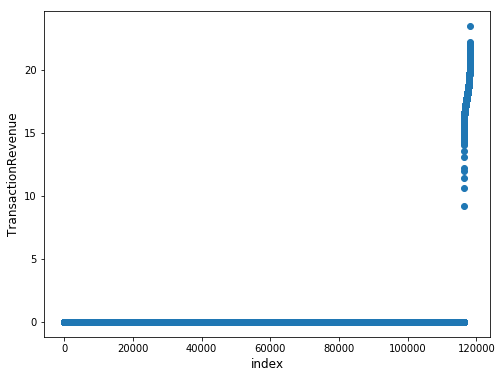

In [12]:
pre_set["totals_transactionRevenue"] = train_df["totals_transactionRevenue"].astype('float')
gdf = pre_set.groupby("fullVisitorId")["totals_transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals_transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

# Change data type and fill missing data.

In [13]:
# Impute 0 for missing target values
pre_set["totals_transactionRevenue"] = pre_set["totals_transactionRevenue"].fillna(0).astype(float)
train_set["totals_transactionRevenue"] = train_set["totals_transactionRevenue"].fillna(0).astype(float)
val_set["totals_transactionRevenue"] = val_set["totals_transactionRevenue"].fillna(0).astype(float)
test_set["totals_transactionRevenue"] = test_set["totals_transactionRevenue"].fillna(0).astype(float)

pre_y = pre_set["totals_transactionRevenue"].values
train_y = train_set["totals_transactionRevenue"].values
val_y = val_set["totals_transactionRevenue"].values
test_y = test_set["totals_transactionRevenue"].values

pre_id = pre_set["fullVisitorId"].values
train_id = train_set["fullVisitorId"].values
val_id = val_set["fullVisitorId"].values
test_id = test_set["fullVisitorId"].values

In [14]:
# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device_browser", 
            "device_deviceCategory", "device_operatingSystem", 
            "geoNetwork_city", "geoNetwork_continent", 
            "geoNetwork_country", "geoNetwork_metro",
            "geoNetwork_networkDomain", "geoNetwork_region", 
            "geoNetwork_subContinent", "trafficSource_adContent", 
            "trafficSource_adwordsClickInfo.adNetworkType", 
            "trafficSource_adwordsClickInfo.gclId", 
            "trafficSource_adwordsClickInfo.page", 
            "trafficSource_adwordsClickInfo.slot", "trafficSource_campaign",
            "trafficSource_keyword", "trafficSource_medium", 
            "trafficSource_source",'trafficSource_adwordsClickInfo.isVideoAd', 'trafficSource_isTrueDirect']
for col in cat_cols:
    print(col)
    lbl = sklearn.preprocessing.LabelEncoder()
    lbl.fit(list(pre_set[col].values.astype('str')) + list(train_set[col].values.astype('str')) + list(val_set[col].values.astype('str')) + list(test_set[col].values.astype('str')))
    pre_set[col] = lbl.transform(list(pre_set[col].values.astype('str')))
    train_set[col] = lbl.transform(list(train_set[col].values.astype('str')))
    val_set[col] = lbl.transform(list(val_set[col].values.astype('str')))
    test_set[col] = lbl.transform(list(test_set[col].values.astype('str')))

channelGrouping
device_browser
device_deviceCategory
device_operatingSystem
geoNetwork_city
geoNetwork_continent
geoNetwork_country
geoNetwork_metro
geoNetwork_networkDomain
geoNetwork_region
geoNetwork_subContinent
trafficSource_adContent
trafficSource_adwordsClickInfo.adNetworkType
trafficSource_adwordsClickInfo.gclId
trafficSource_adwordsClickInfo.page
trafficSource_adwordsClickInfo.slot
trafficSource_campaign
trafficSource_keyword
trafficSource_medium
trafficSource_source
trafficSource_adwordsClickInfo.isVideoAd
trafficSource_isTrueDirect


In [15]:
num_cols = ["totals_hits", "totals_pageviews","visitStartTime", "visitNumber", 'totals_bounces',  'totals_newVisits']    
for col in num_cols:
    pre_set[col] = pre_set[col].fillna(0).astype(float)
    train_set[col] = train_set[col].fillna(0).astype(float)
    val_set[col] = val_set[col].fillna(0).astype(float)
    test_set[col] = test_set[col].fillna(0).astype(float)

In [16]:
pre_set.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,totals_bounces,totals_hits,totals_newVisits,totals_pageviews,totals_sessionQualityDim,totals_timeOnSite,totals_totalTransactionRevenue,totals_transactionRevenue,totals_transactions,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,customDimensions_value
2989,4,2016-09-02,9499785259412240342,1472812272,1.0,1.472812e+09,64,0,False,22,1096,4,144,129,7726,517,22,1.0,1.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,86,3,67994,1,11,5,4,1,8,5,NaN,117,EMEA
2990,4,2016-09-02,3696906537737368442,1472856874,1.0,1.472857e+09,55,0,False,22,157,2,9,0,32822,68,15,1.0,1.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,86,3,67994,1,11,5,4,1,8,5,NaN,117,South America
2991,4,2016-09-02,5688512451361930466,1472811524,1.0,1.472812e+09,55,0,False,6,108,3,93,0,906,221,18,1.0,1.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,86,3,67994,1,11,5,4,1,8,5,NaN,117,APAC
2992,4,2016-09-02,9716453263501147451,1472823508,1.0,1.472824e+09,102,1,True,25,660,3,93,0,44691,126,18,1.0,1.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,86,3,67994,1,11,5,4,1,8,5,NaN,117,APAC
2993,4,2016-09-02,5330453591145100432,1472839619,1.0,1.472840e+09,55,0,False,22,886,2,28,0,41583,444,15,1.0,1.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,86,3,67994,1,11,5,4,1,8,5,NaN,117,South America


In [17]:
pre_set.corr()["totals_transactionRevenue"].sort_values(ascending=False)

totals_transactionRevenue                       1.000000
totals_pageviews                                0.164504
totals_hits                                     0.160285
geoNetwork_country                              0.023648
visitNumber                                     0.007954
trafficSource_keyword                           0.006257
trafficSource_adContent                         0.001633
visitStartTime                                 -0.000714
visitId                                        -0.000714
geoNetwork_metro                               -0.001401
trafficSource_adwordsClickInfo.slot            -0.002226
trafficSource_adwordsClickInfo.adNetworkType   -0.002414
trafficSource_adwordsClickInfo.isVideoAd       -0.002414
trafficSource_adwordsClickInfo.page            -0.002424
trafficSource_adwordsClickInfo.gclId           -0.002942
trafficSource_campaign                         -0.004538
geoNetwork_region                              -0.008035
channelGrouping                

## Choosing a subset of features.

In [18]:
train_x = train_set[cat_cols + num_cols] 
val_x = val_set[cat_cols + num_cols] 
test_x = test_set[cat_cols + num_cols] 

In [19]:
train_x.head()

,channelGrouping,device_browser,device_deviceCategory,device_operatingSystem,geoNetwork_city,geoNetwork_continent,geoNetwork_country,geoNetwork_metro,geoNetwork_networkDomain,geoNetwork_region,geoNetwork_subContinent,trafficSource_adContent,trafficSource_adwordsClickInfo.adNetworkType,trafficSource_adwordsClickInfo.gclId,trafficSource_adwordsClickInfo.page,trafficSource_adwordsClickInfo.slot,trafficSource_campaign,trafficSource_keyword,trafficSource_medium,trafficSource_source,trafficSource_adwordsClickInfo.isVideoAd,trafficSource_isTrueDirect,totals_hits,totals_pageviews,visitStartTime,visitNumber,totals_bounces,totals_newVisits
0,4,64,0,22,1096,4,75,129,0,517,22,86,3,67994,11,5,4,3761,5,117,1,1,1.0,1.0,1.508198e+09,1.0,1.0,1.0
1,6,55,0,3,256,2,219,104,0,74,12,86,3,67994,11,5,4,3086,6,339,1,1,2.0,2.0,1.508176e+09,6.0,0.0,0.0
2,2,55,1,1,1096,2,219,129,47195,517,12,86,3,67994,11,5,4,3086,0,0,1,0,2.0,2.0,1.508202e+09,1.0,0.0,1.0
3,4,55,0,22,1096,3,211,129,44691,517,21,86,3,67994,11,5,4,8,5,117,1,1,2.0,2.0,1.508170e+09,1.0,0.0,1.0
4,4,55,0,22,1096,2,132,129,33811,517,3,86,3,67994,11,5,4,8,5,117,1,1,2.0,2.0,1.508191e+09,1.0,0.0,1.0


# Train & Test

In [20]:
def get_mse(pred_y, true_y, visitor_id):
    pred_y[pred_y<0] = 0
    pred_y_df = pd.DataFrame({"fullVisitorId":visitor_id})
    pred_y_df["transactionRevenue"] = true_y
    pred_y_df["PredictedRevenue"] = pred_y
    pred_y_df = pred_y_df.groupby("fullVisitorId")["transactionRevenue", "PredictedRevenue"].sum().reset_index()
    return (np.sqrt(metrics.mean_squared_error(np.log1p(pred_y_df["transactionRevenue"].values), np.log1p(pred_y_df["PredictedRevenue"].values))))

## Linear Regression

In [21]:
lin_reg = LinearRegression().fit(train_x, train_y)
pred_val_y = lin_reg.predict(val_x)
pred_test_y = lin_reg.predict(test_x)

In [22]:
mse_lin = get_mse(pred_val_y, val_y, val_id)
mse_lin

8.664401065570745

## Lasso

In [23]:
alphas = [0.01,0.1,1,10,100]

In [24]:
for a in alphas:
    lasso_reg = Lasso(alpha = a).fit(train_x, train_y)
    pred_val_y = lasso_reg.predict(val_x)
    pred_test_y = lasso_reg.predict(test_x)
    print("alpha is " + str(a))
    print("mse is " + str(get_mse(pred_val_y, val_y, val_id)))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



alpha is 0.01
mse is 8.664327116930957


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



alpha is 0.1
mse is 8.664330868284313


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



alpha is 1
mse is 8.664357106723406


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



alpha is 10
mse is 8.664520874909705


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



alpha is 100
mse is 8.665590489375765


## Ridge

In [25]:
alphas = [0.01,0.1,1,10,100]

In [26]:
for a in alphas:
    ridge_reg = Ridge(alpha = a).fit(train_x, train_y)
    pred_val_y = ridge_reg.predict(val_x)
    pred_test_y = ridge_reg.predict(test_x)
    print("alpha is " + str(a))
    print("mse is" + str(get_mse(pred_val_y, val_y, val_id)))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning:

scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.643702e-19



alpha is 0.01
mse is8.664401071490563


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning:

scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.647722e-19



alpha is 0.1
mse is8.66440108367824


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning:

scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.687930e-19



alpha is 1
mse is8.664396296517642


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning:

scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.091417e-19



alpha is 10
mse is8.664436670639697


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning:

scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.238331e-19



alpha is 100
mse is8.664089500399202


## light GBM

In [27]:
# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test_y, model, pred_val_y = run_lgb(train_x, train_y, val_x, val_y, test_x)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.26825e+07
Early stopping, best iteration is:
[19]	valid_0's rmse: 2.23313e+07


In [28]:
mse_lgb = get_mse(pred_val_y, val_y, val_id)
mse_lgb

12.42734552951002

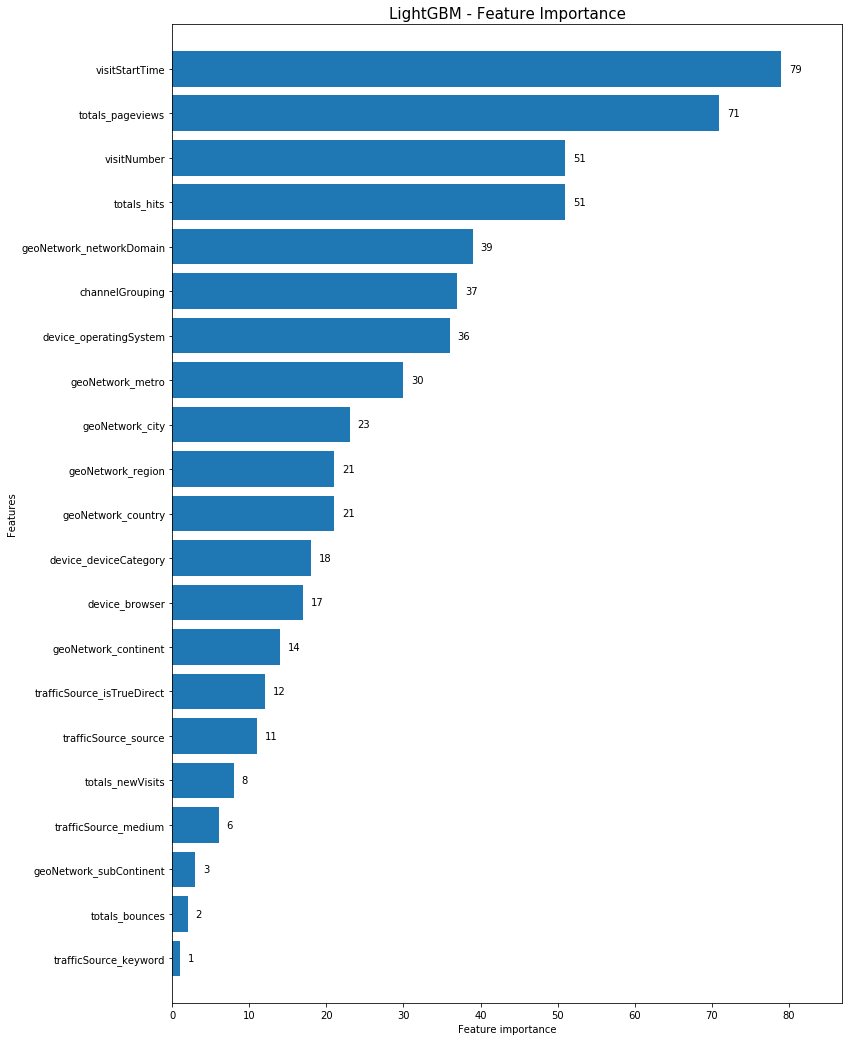

In [29]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

## Select a subset of features to build Random Forest model.

In [30]:
model.feature_importance()

array([37, 17, 18, 36, 23, 14, 21, 30, 39, 21,  3,  0,  0,  0,  0,  0,  0,
        1,  6, 11,  0, 12, 51, 71, 79, 51,  2,  8])

In [31]:
selected = model.feature_importance() > 30

In [32]:
selected

array([ True, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True, False,
       False])

In [33]:
all_features = model.feature_name()
selected_features = []

In [34]:
for i in range(len(selected)):
    if selected[i]==True:
        selected_features.append(all_features[i])

In [35]:
selected_features

['channelGrouping',
 'device_operatingSystem',
 'geoNetwork_networkDomain',
 'totals_hits',
 'totals_pageviews',
 'visitStartTime',
 'visitNumber']

In [36]:
train_x_selected = train_x[selected_features]
val_x_selected = val_x[selected_features]
test_x_selected = test_x[selected_features]

## Random Forest

In [37]:
rf_reg = RandomForestRegressor(n_estimators = 20)

In [38]:
rf_reg = rf_reg.fit(train_x_selected, train_y)

In [39]:
pred_val_y = rf_reg.predict(val_x_selected)

In [40]:
mse_rf = get_mse(pred_val_y, val_y, val_id)
mse_rf

3.8862266674554617

## Test and Output

In [41]:
pred_test_y = rf_reg.predict(test_x_selected)
mse_rf = get_mse(pred_test_y, test_y, test_id)
mse_rf

4.582839360736201

In [ ]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test_y[pred_test_y<0] = 0
sub_df["PredictedLogRevenue"] = pred_test_y
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("random_forest.csv", index=False)

In [ ]:
sub_df.head(14)

In [ ]:
sub_df.shape